In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import requests
import time

In [19]:
model = tf.keras.models.load_model("../models/model.keras")

In [20]:
#Read test data
df = pd.read_csv('prices.log', header=None, names=["Price", "Timestamp"])
prices = np.array(df['Price']).reshape(-1, 1)

In [21]:
#Set min-max scaler to same as model
model_data = pd.read_csv('../model_data.csv')
model_prices = np.array(model_data['price'])

# Load the same MinMaxScaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = RobustScaler()
scaler.fit(model_prices.reshape(-1, 1))  # Fit on the current live prices

MinMaxScaler()

In [22]:
#read test data
df = pd.read_csv('../recent_eth_prices.csv')
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,exchange,bid,ask
0,0,610378394,ETH-USD,2693.31,0.002662,2025-02-15 23:04:16.929545+00:00,SELL,NaN,NaN,NaN
1,1,610378498,ETH-USD,2693.07,0.003294,2025-02-15 23:04:31.279857+00:00,SELL,NaN,NaN,NaN
2,2,610378533,ETH-USD,2693.89,0.003243,2025-02-15 23:04:46.953075+00:00,SELL,NaN,NaN,NaN
3,3,610378584,ETH-USD,2693.66,0.002293,2025-02-15 23:05:01.536506+00:00,SELL,NaN,NaN,NaN
4,4,610378657,ETH-USD,2693.98,0.000537,2025-02-15 23:05:16.783522+00:00,SELL,NaN,NaN,NaN


In [23]:
# Scale prices to match training format
prices_original = df['price'].values.reshape(-1, 1)
df['transformed_price'] = scaler.transform(prices_original)
df['sma_5'] = df['transformed_price'].rolling(window=5).mean()
df['momentum'] = df['transformed_price'] - df['transformed_price'].shift(5)
df['price_scaled'] = scaler.fit_transform(df[['price']])
df['pct_change'] = df['price'].pct_change() * 100  # Convert to percentage
df.dropna(subset=['sma_5', 'momentum'], inplace=True)
df.head()

prices = df['price_scaled'].values
sma_5 = df['sma_5'].values
momentum = df['momentum'].values

In [24]:
# Prepare the data for LSTM (same sequence length used in training)
X_test = []
last_price = []

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5  # Predict 5 steps into the future

for i in range(0, len((prices) - sequence_length - forecast_steps), sequence_length):
    try:
        #build feature set
        row = []
        row.append(np.array(prices[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(sma_5[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(momentum[i:i + sequence_length]).reshape(sequence_length, 1))

        X_test.append(prices[i:i + sequence_length])
        #X_test.append(np.array(row).reshape(len(row), sequence_length))
        last_price.append(prices_original[i + sequence_length])
    except ValueError:
        break

X_test = np.array(X_test)

In [25]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual price values
predicted_prices = scaler.inverse_transform(predictions)

442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [26]:
len(predictions)

14124

In [27]:
#pull real prices to compare with predictions
prices_to_compare = []
step_length = 5
for i in range(sequence_length + step_length - 1, len(prices), sequence_length):
    prices_to_compare.append(prices_original[i])

len(prices_to_compare)

14124

In [28]:
def print_percent_diff(A, B):
    # Compute % difference for each element
    percent_diff = np.abs(A - B) / ((A + B) / 2) * 100

    # Compute and print the average percentage difference
    average_percent_diff = np.mean(percent_diff)
    print("Average Percentage Difference:", average_percent_diff)

In [29]:
print_percent_diff(predicted_prices, prices_to_compare)

Average Percentage Difference: 0.037899945241934796


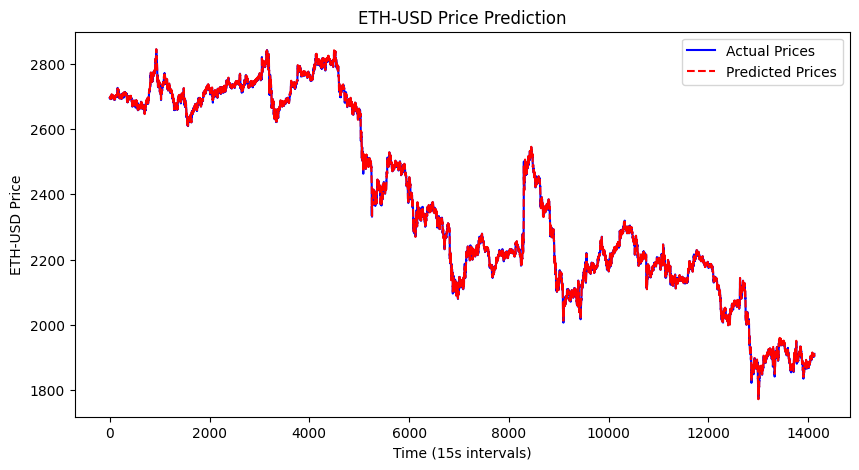

In [30]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(prices_to_compare, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Time (15s intervals)")
plt.ylabel("ETH-USD Price")
plt.legend()
plt.title("ETH-USD Price Prediction")
plt.show()

In [31]:
correct_buy_predictions = 0
incorrect_buy_predictions = 0
correct_sell_predictions = 0
incorrect_sell_predictions = 0

for i in range(len(predicted_prices)):
    # Real price of ETH
    real_price = prices_to_compare[i]
    #Predicted price of ETH
    predicted_price = predicted_prices[i]
    #Price 5 timestamps ago
    previous_price = last_price[i]

    #Check if both prediction and real price were up or down
    if (real_price - previous_price > 0 and predicted_price - previous_price > 0):
        correct_buy_predictions += 1
    elif( real_price - previous_price < 0 and predicted_price - previous_price > 0):
        incorrect_buy_predictions += 1
    elif (real_price - previous_price < 0 and predicted_price - previous_price < 0):
        correct_sell_predictions += 1
    elif (real_price - previous_price > 0 and predicted_price - previous_price < 0):
        incorrect_sell_predictions += 1

if correct_sell_predictions + incorrect_sell_predictions > 0:
    print(f"SELL Predictions: {correct_sell_predictions + incorrect_sell_predictions} Correct: {correct_sell_predictions} Incorrect: {incorrect_sell_predictions} Correct Rate: {(correct_sell_predictions/(correct_sell_predictions + incorrect_sell_predictions) * 100)}%")
if correct_buy_predictions + incorrect_buy_predictions > 0:
    print(f"BUY Predictions: {correct_buy_predictions + incorrect_buy_predictions} Correct: {correct_buy_predictions} Incorrect: {incorrect_buy_predictions} Correct Rate: {(correct_buy_predictions/(correct_buy_predictions + incorrect_buy_predictions) * 100)}%")
total_correct = correct_buy_predictions + correct_sell_predictions
total_incorrect = incorrect_buy_predictions + incorrect_sell_predictions
print(f"Overall correct rate: {(total_correct/len(predicted_prices))*100}%")


SELL Predictions: 5082 Correct: 4919 Incorrect: 163 Correct Rate: 96.79260133805589%
BUY Predictions: 9017 Correct: 6875 Incorrect: 2142 Correct Rate: 76.24487079960075%
Overall correct rate: 83.50325686774285%
